In [168]:
import os
import csv

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import keras
import tensorflow as tf
import random as python_random
from keras import layers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import LSTM, CuDNNLSTM, Dense, Dropout, Input, ConvLSTM2D, Flatten, Add, Concatenate, Dot, Multiply
from keras.layers import Maximum, Average, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils.vis_utils import plot_model
import math
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

from keras import backend as K

import pandas.io.sql as sqlio
import psycopg2
import getpass

import matplotlib.pyplot as plt

from src.visualize import plot_sequence

In [169]:
tf.test.is_gpu_available()

True

# 0. Config

In [170]:
models_to_train = [
    'dynamic_lstm',
    'full_lstm',
    'rf',
    '1-NN'
]

model_to_explain = 'full_lstm'

In [171]:
# Define data paths
data_path = '../processed_mimic_data/'
drg_path = '../drg_models'

# Load training data
train_pos = pd.read_csv(data_path + 'train_pos.txt')
train_neg = pd.read_csv(data_path + 'train_neg.txt')

# Load test data


# Add target class label
train_pos['survival'] = [1 for i in range(train_pos.shape[0])]
train_neg['survival'] = [0 for i in range(train_neg.shape[0])]

# Set static feature names
static_feature_names = [
    'gender',
    'age',
    'los_hospital',
    'ethnicity',
    'admission_type',
    'first_hosp_stay',
    'first_icu_stay'
]

Concatinate the drug and procedure codes into a single feature

In [172]:
train_neg['events'] = train_neg['drug_events'] + " " + train_neg['procedure_codes']
train_pos['events'] = train_pos['drug_events'] + " " + train_pos['procedure_codes']

In [173]:
# Concat into one data frame; and reorder it
train = pd.concat([train_pos, train_neg]).reset_index()[['survival', 'events'] + static_feature_names].dropna()
train_reordered = train.sample(frac=1, random_state=3)

In [174]:
train_reordered[static_feature_names] = preprocessing.MinMaxScaler().fit_transform(
    train_reordered[static_feature_names].values)

In [175]:
X_train_events, X_train_static, y_train = train_reordered['events'], train_reordered[static_feature_names], train_reordered['survival']

In [176]:
static_feature_names

['gender',
 'age',
 'los_hospital',
 'ethnicity',
 'admission_type',
 'first_hosp_stay',
 'first_icu_stay']

In [177]:
X_train_static

,gender,age,los_hospital,ethnicity,admission_type,first_hosp_stay,first_icu_stay
2367,1.0,1.000000,0.034031,0.025,0.0,0.0,0.0
4760,1.0,1.000000,0.034914,0.025,0.0,0.0,0.0
24,1.0,0.449583,0.048671,0.075,0.0,1.0,0.0
3704,0.0,0.758303,0.016734,0.450,0.0,0.0,0.0
4267,1.0,0.525779,0.053804,0.025,0.0,1.0,0.0
...,...,...,...,...,...,...,...
968,0.0,0.911766,0.038537,0.025,0.0,0.0,0.0
1667,0.0,0.285384,0.053816,0.450,0.0,0.0,0.0
3322,1.0,0.781714,0.052194,0.025,0.0,0.0,0.0
1688,0.0,0.506551,0.034477,0.025,0.0,1.0,0.0


In [178]:
# Load validation data
validation_pos = pd.read_csv(data_path + 'validation_pos.txt')
validation_neg = pd.read_csv(data_path + 'validation_neg.txt')

# Add target class
validation_pos['survival'] = [1 for i in range(validation_pos.shape[0])]
validation_neg['survival'] = [0 for i in range(validation_neg.shape[0])]

validation_neg['events'] = validation_neg['drug_events'] + " " + validation_neg['procedure_codes']
validation_pos['events'] = validation_pos['drug_events'] + " " + validation_pos['procedure_codes']

In [179]:
validation_pos

,subject_id,drug_events,procedure_codes,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,...,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,first_icu_stay,survival,events
0,84818,225910 225823 225910 225823 225910 225823 2259...,4513 4523,175593.0,226866.0,0.0,NaN,2122-06-19 20:41:00,2122-06-24 12:24:00,4.6549,...,0.0,1.0,0.0,2122-06-19 20:42:04,2122-06-21 15:37:24,1.7884,1.0,0.0,1,225910 225823 225910 225823 225910 225823 2259...
1,99412,222042 220970 220970 226364 225907 225799 2258...,3972 8841,192975.0,295903.0,1.0,NaN,2142-04-24 12:19:00,2142-05-03 13:00:00,9.0285,...,0.0,1.0,0.0,2142-04-24 14:50:11,2142-04-30 17:58:10,6.1305,1.0,0.0,1,222042 220970 220970 226364 225907 225799 2258...
2,77487,225910 226361 225910 225910,4513 4516 4513 8604,144009.0,250934.0,0.0,NaN,2198-11-17 09:15:00,2198-11-23 19:57:00,6.4458,...,0.0,2.0,1.0,2198-11-17 09:16:18,2198-11-18 14:24:09,1.2138,1.0,0.0,1,225910 226361 225910 225910 4513 4516 4513 8604
3,63219,226364 226372 222168 222056 225154 225154 2214...,3615 3961,194579.0,220120.0,0.0,NaN,2130-11-15 07:30:00,2130-11-19 13:40:00,4.2569,...,0.0,1.0,0.0,2130-11-15 11:28:52,2130-11-16 11:42:45,1.0096,1.0,0.0,1,226364 226372 222168 222056 225154 225154 2214...
4,46060,226361 225168 226361 226361 220970 225154 2217...,9907 9904,123807.0,268137.0,1.0,NaN,2181-09-05 12:00:00,2181-09-14 21:32:00,9.3972,...,0.0,1.0,0.0,2181-09-09 01:45:54,2181-09-11 15:24:40,2.5686,1.0,0.0,1,226361 225168 226361 226361 220970 225154 2217...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,70314,226361 225154 220995 225154 225154 225154 2251...,4131 3893 5013 8864 3897 3897 9925 370 0392 99...,129845.0,206464.0,1.0,NaN,2191-11-24 15:33:00,2192-01-13 17:53:00,50.0972,...,0.0,1.0,0.0,2191-11-28 20:58:28,2191-11-29 18:35:18,0.9006,1.0,0.0,1,226361 225154 220995 225154 225154 225154 2251...
196,43736,225151 225159 223262 225159 223258,0066 3607 9920 0046 0040 8856 3778,143451.0,246005.0,1.0,NaN,2137-12-28 22:50:00,2138-01-03 15:15:00,5.6840,...,0.0,1.0,0.0,2138-01-01 18:37:36,2138-01-02 12:54:44,0.7619,1.0,0.0,1,225151 225159 223262 225159 223258 0066 3607 9...
197,51754,225910 220970 220970 225168 225168 220995 2251...,4523 4513 4513 4523 4513 3734 3722 3964 8856,105236.0,257838.0,0.0,NaN,2100-10-31 21:51:00,2100-11-03 10:15:00,2.5167,...,0.0,2.0,1.0,2100-10-31 21:52:03,2100-11-03 10:58:55,2.5464,1.0,0.0,1,225910 220970 220970 225168 225168 220995 2251...
198,42180,221986 222168 225828 227522 225166 225828 2258...,3929 8411 3527 3774 3787 3776 3961,135448.0,212790.0,0.0,NaN,2114-12-27 07:15:00,2115-01-01 13:15:00,5.2500,...,0.0,1.0,0.0,2114-12-27 11:00:10,2114-12-29 22:13:50,2.4678,1.0,0.0,1,221986 222168 225828 227522 225166 225828 2258...


In [180]:
train_neg['events'] = train_neg['drug_events'] + " " + train_neg['procedure_codes']
train_pos['events'] = train_pos['drug_events'] + " " + train_pos['procedure_codes']

In [181]:
validation = pd.concat([validation_pos, validation_neg]).reset_index()
validation_reordered = validation.sample(frac=1, random_state=3)

X_val_neg_static = validation_neg[static_feature_names]
X_val_events, X_val_static, y_val = validation_reordered["events"], validation_reordered[static_feature_names],validation_reordered['survival']

In [182]:
X_val_events.head()

376    225893 225798 221794 225893 225893 221794 2258...
16                        226361 225168 225910 4525 4513
365    226361 225798 225975 223262 223262 225855 2259...
82     221468 221794 221468 221794 221347 225152 2213...
107    225910 220970 225168 221794 225910 225884 2216...
Name: events, dtype: object

### Data preprocessing

#### 1.1 Conver all the events into sequence (token) ids

In [183]:
# Set the vocab size and max sequence lenght
vocab_size = 1100  #(max vocab id=1024 in the training data)
max_seq_length = 74  #(the maximum sequence length in training/testing data)

In [184]:
# Use a text tokenizer to convert events
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_events)

In [185]:
X_train_sequences = tokenizer.texts_to_sequences(X_train_events)
X_val_sequences = tokenizer.texts_to_sequences(X_val_events)

In [186]:
# Before texts_to_sequences()
print(f'Before texts_to_sequences():\n {X_train_events.iloc[0]}\n')

# After texts_to_sequences()
print(f'After texts_to_sequences():\n {X_train_sequences[0]}')

Before texts_to_sequences():
 220995 220995 223262 221456 227523 222011 225975 223262 4525

After texts_to_sequences():
 [48, 48, 7, 30, 20, 14, 2, 7, 212]


#### 1.2 Padding converted sequences

In [187]:
# Pad X_train_sequences and X_val_sequences
X_train_padded = sequence.pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')
X_val_padded = sequence.pad_sequences(X_val_sequences, maxlen=max_seq_length, padding='post')

In [188]:
X_train_padded.shape

(6041, 74)

In [189]:
X_val_padded.shape

(400, 74)

In [190]:
X_val_padded

array([[22, 11, 12, ...,  0,  0,  0],
       [21,  9, 15, ...,  0,  0,  0],
       [21, 11,  2, ...,  0,  0,  0],
       ...,
       [13,  5, 16, ...,  0,  0,  0],
       [ 9, 21,  9, ...,  0,  0,  0],
       [12, 21, 11, ...,  0,  0,  0]])

# Train models

In [191]:
## 2. Train prediction models
# For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [192]:
def eval_model_preds(preds, reference):
    # Calculate the validation accuracy
    validation_acc = accuracy_score(y_true=reference, y_pred=preds)
    f1 = f1_score(y_true=reference, y_pred=preds)
    print(f'Validation Accuracy: {validation_acc}')
    print()

    print(f'F1 Score: {f1}')
    print()
    # Get the confusion matrix
    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=reference, y_pred=preds, labels=[1, 0]),
        index=['True:pos', 'True:neg'],
        columns=['Pred:pos', 'Pred:neg']
    )
    print('Confusion Matrix:')
    print(confusion_matrix_df)
    print()

    # Counts of positive and negative predictions
    print('Negative and positive predictions')
    print(pd.value_counts(preds))

In [193]:
# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

### 2.1 Train the dynamic feature LSTM

In [194]:
# Fix the random seeds to get consistent models
## ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
seed_value = 3

os.environ['PYTHONHASHSEED'] = str(seed_value)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed_value)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(seed_value)

# The below set_seed() will make random number generation
tf.random.set_seed(seed_value)

# configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


def reset_seeds(seed_value=3):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)


reset_seeds()

In [195]:
# Define the model structure
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(vocab_size, 128)(inputs)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(64)(x)
x = layers.Dense(64)(x)

# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
dynamic_lstm_model = keras.Model(inputs, outputs)

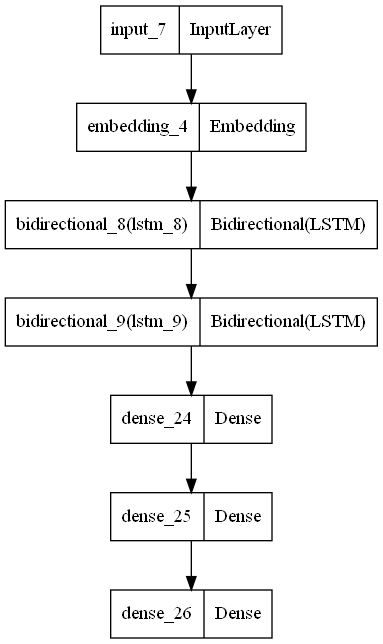

In [196]:
plot_model(dynamic_lstm_model)

In [197]:
dynamic_lstm_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 128)         140800    
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 64)                4160

Epoch 1/30
95/95 [==============================] - 11s 56ms/step - loss: 0.5837 - accuracy: 0.6919 - val_loss: 0.5690 - val_accuracy: 0.7050
Epoch 2/30
95/95 [==============================] - 4s 38ms/step - loss: 0.4952 - accuracy: 0.7578 - val_loss: 0.5505 - val_accuracy: 0.7000
Epoch 3/30
95/95 [==============================] - 4s 38ms/step - loss: 0.4458 - accuracy: 0.7921 - val_loss: 0.5189 - val_accuracy: 0.7350
Epoch 4/30
95/95 [==============================] - 4s 38ms/step - loss: 0.4028 - accuracy: 0.8118 - val_loss: 0.5250 - val_accuracy: 0.7525
Epoch 5/30
95/95 [==============================] - 4s 39ms/step - loss: 0.3816 - accuracy: 0.8317 - val_loss: 0.4845 - val_accuracy: 0.7650
Epoch 6/30
95/95 [==============================] - 4s 38ms/step - loss: 0.3462 - accuracy: 0.8497 - val_loss: 0.4614 - val_accuracy: 0.7650
Epoch 7/30
95/95 [==============================] - 4s 42ms/step - loss: 0.3204 - accuracy: 0.8649 - val_loss: 0.4849 - val_accuracy: 0.8050
Epoch 8/30
9

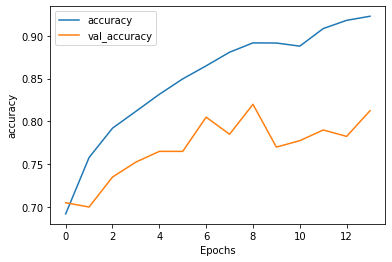

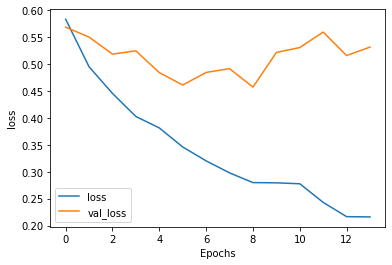

Validation Accuracy: 0.8125

F1 Score: 0.8243559718969555

Confusion Matrix:
          Pred:pos  Pred:neg
True:pos       176        24
True:neg        51       149

Negative and positive predictions
1    227
0    173
dtype: int64


In [198]:
if 'dynamic_lstm' in models_to_train:
    dynamic_lstm_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    reset_seeds()

    model_history = dynamic_lstm_model.fit(
        X_train_padded,
        y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_val_padded, y_val),
        callbacks=[early_stopping]
    )
    # Visualize the training/validation accuracy and loss
    plot_graphs(model_history, "accuracy")
    plot_graphs(model_history, "loss")

    # Get the predicted target class: if pred > 0.5, then y_pred = 1; else, y_pred = 0
    dynamic_lstm_pred = np.array([1 if pred > 0.5 else 0 for pred in dynamic_lstm_model.predict(X_val_padded)])
    eval_model_preds(dynamic_lstm_pred, y_val)

### 2.2 Train full feature LSTM

In [199]:
# Fix the random seeds to get consistent models
## ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
seed_value = 3

os.environ['PYTHONHASHSEED'] = str(seed_value)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed_value)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(seed_value)

# The below set_seed() will make random number generation
tf.random.set_seed(seed_value)

# configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

reset_seeds()

In [200]:
# dynamic features
x_i_dyn = Input(shape=(None,), dtype="int32")
x = layers.Embedding(vocab_size, 128)(x_i_dyn)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x_pa = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(64)(x_pa)
x_dyn = layers.Dense(64)(x)

# static features
x_i_stat = Input(shape=(len(static_feature_names),))
x2 = layers.Dense(64)(x_i_stat)
x2 = layers.Activation('relu')(x2)
x_pa2 = layers.Dense(64)(x2)
x2 = Activation('relu')(x_pa2)
x_stat = Dropout(0.1)(x2)

# combined part
x_dot = Dot(axes=1, normalize=True)([x_stat, x_dyn])
x = layers.Dense(128)(x_dot)
x = Activation('relu')(x)
x = layers.Dense(128)(x)
x = layers.Dense(128)(x)
x = Activation('relu')(x)
x = layers.Dense(128)(x)

x_o = Dense(1, activation="sigmoid")(x)

full_lstm_model = Model([x_i_dyn, x_i_stat], x_o)

full_lstm_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

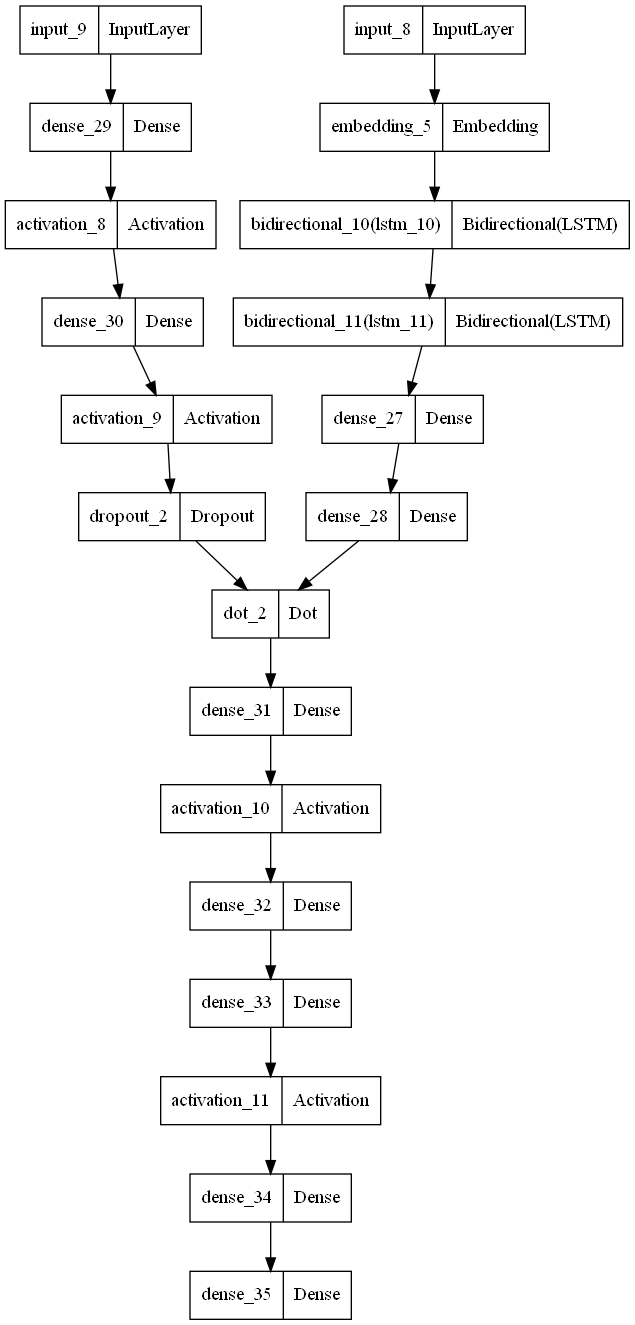

In [201]:
plot_model(full_lstm_model)

In [202]:
full_lstm_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 dense_29 (Dense)               (None, 64)           512         ['input_9[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, None, 128)    140800      ['input_8[0][0]']                
                                                                                            

Epoch 1/100
95/95 [==============================] - 9s 53ms/step - loss: 0.6010 - accuracy: 0.6605 - val_loss: 0.6359 - val_accuracy: 0.6625
Epoch 2/100
95/95 [==============================] - 4s 40ms/step - loss: 0.5115 - accuracy: 0.7449 - val_loss: 0.6095 - val_accuracy: 0.6675
Epoch 3/100
95/95 [==============================] - 4s 40ms/step - loss: 0.4502 - accuracy: 0.7901 - val_loss: 0.5540 - val_accuracy: 0.7225
Epoch 4/100
95/95 [==============================] - 4s 40ms/step - loss: 0.3954 - accuracy: 0.8171 - val_loss: 0.6512 - val_accuracy: 0.6850
Epoch 5/100
95/95 [==============================] - 4s 41ms/step - loss: 0.3764 - accuracy: 0.8297 - val_loss: 0.6063 - val_accuracy: 0.7050
Epoch 6/100
95/95 [==============================] - 4s 39ms/step - loss: 0.3499 - accuracy: 0.8542 - val_loss: 0.5563 - val_accuracy: 0.7400
Epoch 7/100
95/95 [==============================] - 4s 39ms/step - loss: 0.3292 - accuracy: 0.8580 - val_loss: 0.5807 - val_accuracy: 0.7400
Epoch 

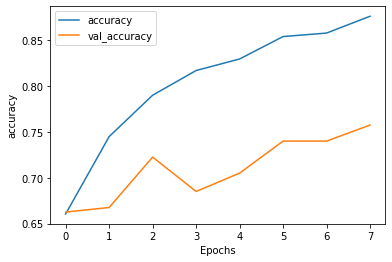

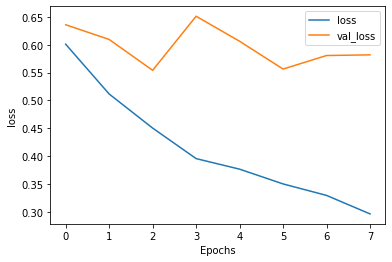

Validation Accuracy: 0.7575

F1 Score: 0.7138643067846607

Confusion Matrix:
          Pred:pos  Pred:neg
True:pos       121        79
True:neg        18       182

Negative and positive predictions
0    261
1    139
dtype: int64


In [203]:
if 'full_lstm' in models_to_train:
    full_lstm_hist = full_lstm_model.fit(
        [X_train_padded, X_train_static],
        y_train,
        epochs=100,
        batch_size=64,
        validation_data=([X_val_padded, X_val_static], y_val),
        callbacks=early_stopping
    )
    # Visualize the training/validation accuracy and loss
    plot_graphs(full_lstm_hist, "accuracy")
    plot_graphs(full_lstm_hist, "loss")
    # Get the predicted target class: if pred > 0.5, then y_pred = 1; else, y_pred = 0
    full_lstm_pred = np.array(
        [1 if pred > 0.5 else 0 for pred in full_lstm_model.predict([X_val_padded, X_val_static])])
    eval_model_preds(full_lstm_pred, y_val)

## 2.3 Train RF on the static features

In [204]:
if 'rf' in models_to_train:
    rf = RandomForestClassifier()
    rf.fit(X_train_static, y_train)
    rf_pred = rf.predict(X_val_static)
    eval_model_preds(rf_pred, y_val)

Validation Accuracy: 0.465

F1 Score: 0.5114155251141552

Confusion Matrix:
          Pred:pos  Pred:neg
True:pos       112        88
True:neg       126        74

Negative and positive predictions
1    238
0    162
dtype: int64


## 3. Get the negative predictions from LSTM, for counterfactual explanations

In [205]:
# Get these instances of negative predictions
if model_to_explain == 'dynamic_lstm':
    y_pred = dynamic_lstm_pred
    model = dynamic_lstm_model
if model_to_explain == 'full_lstm':
    y_pred = full_lstm_pred
    model = full_lstm_model
if model_to_explain == 'rf':
    y_pred = rf_pred
    model = rf

X_pred_negative = X_val_padded[y_pred == 0]
X_pred_negative_static = X_val_static[y_pred == 0]

In [206]:
X_pred_negative.shape

(261, 74)

#### Export as the desired input format of the DRG framework

In [207]:
# Convert negatively predicted instances back to medical event form
original_event_sequences = tokenizer.sequences_to_texts(X_pred_negative)

In [208]:
original_event_sequences[:5]

['226361 225168 225910 4525 4513',
 '226361 225798 225975 223262 223262 225855 225975 223258 223258 223260 223258 223258 223258 223258 223260 221906 221662 226361 221906 221668 221906 221906 221906 227533 225893 221668 221906 225152 220995 221906 221906 225798 221906 3893 9604 9671 3893',
 '221468 221794 221468 221794 221347 225152 221347 221824 225152 225152 221824 221347 221824 225152 221824 227694 225152 225152 225152 225152 225152 225152 225152 225152 225152 220970 225152 225152 225152 221794 225152 225152 225152 225152 225152 225152 221794 221794 225152 225152 225152 225152 5122',
 '226361 225879 225798 225798 3324',
 '222011 227523 226089 225860 226361 220970 225860 220970 220970 225855 227522 225166 225860 225798 225855 226089 225974 225974 225974 225798 225798 225975 221794 225166 225944 225974 225944 225166 225855 3897 3897']

In [209]:
pd.DataFrame(original_event_sequences).to_csv(path_or_buf=f'{data_path}/test_neg.txt', index=False, header=False,
                                              sep=' ', quoting=csv.QUOTE_NONE, escapechar=' ')

Here, we need to use the inference script from the DRG framework (instructions in the README file) to modify those 110 negative predictions into positive instances. After that, we import the transformed results as below.

### 3.1 DeleteOnly model results

In [210]:
# Load the transformed data
trans_results_delete = pd.read_csv(f'{drg_path}/drg_delete/preds', header=None)

In [211]:
X_cf_delete = tokenizer.texts_to_sequences(trans_results_delete[0])

X_cf_delete_padded = sequence.pad_sequences(X_cf_delete, maxlen=max_seq_length, padding='post')

### 3.2 DeleteAndRetrieve model results

In [212]:
# Load the transformed data
# TODO change this directory
delete_generate_results = pd.read_csv(f'{drg_path}/drg_delete_retrieve/preds', header=None)

In [213]:
X_cf_delete_retrieve = tokenizer.texts_to_sequences(delete_generate_results[0])

X_cf_delete_retrieve_padded = sequence.pad_sequences(X_cf_delete_retrieve, maxlen=max_seq_length, padding='post')

### 3.3 Use 1NN baseline method to modify the negatively predicted instances

In [214]:
# Fit an unsupervised 1NN with all the positive sequences, using 'hamming' distance
nn_model = NearestNeighbors(n_neighbors=1, metric='hamming')
target_label = 1
X_target_label = X_train_padded[y_train == target_label]

nn_model.fit(X_target_label)

NearestNeighbors(metric='hamming', n_neighbors=1)

In [215]:
# Find the closest neighbor (positive sequence) with the minimum 'hamming' distance, take it as a counterfactual
closest = nn_model.kneighbors(X_pred_negative, return_distance=False)
trans_results_nn = X_target_label[closest[:, 0]]

trans_results_nn[0]

array([ 9,  9, 15, 15, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [216]:
# Rename 'trans_results_nn' to 'X_test_padded3' for result comparison
X_cf_one_nn = trans_results_nn

### 3.4 Convert transformed results to event sequence format

In [217]:
# Convert transformed sequences back to the form of original event sequences
trans_event_delete = tokenizer.sequences_to_texts(X_cf_delete_padded)
trans_event_delete_retrieve = tokenizer.sequences_to_texts(X_cf_delete_retrieve_padded)
trans_event_one_nn = tokenizer.sequences_to_texts(X_cf_one_nn)

## 4. Results comparison

### 4.1 Comparison between fraction of valid CFs (i.e. successfully generated counterfactuals)

In [236]:
# Get the total counts 
test_size = X_pred_negative.shape[0]

In [237]:
# Fraction of valid transformed sequences, for DeleteOnly
if model_to_explain == 'full_lstm':
    fraction_success = np.sum(model.predict([X_cf_delete_padded, X_val_neg_static]) > 0.5) / test_size
elif model_to_explain == "rf":
    fraction_success = np.sum(model.predict(X_val_neg_static) > 0.5) / test_size
else:
    fraction_success = np.sum(model.predict(X_cf_delete_padded) > 0.5) / test_size
print(round(fraction_success, 4))

0.2184


In [238]:
model_to_explain == 'full_lstm'

True

In [241]:
X_cf_one_nn

array([[  9,   9,  15, ...,   0,   0,   0],
       [  7,   7,  21, ...,   0,   0,   0],
       [  2,  12,  13, ...,   0,   0,   0],
       ...,
       [ 16,  36,   8, ...,   0,   0,   0],
       [  9,  21,   9, ...,   0,   0,   0],
       [109,  21,  19, ...,   0,   0,   0]])

In [242]:
# For DeleteAndRetrieve
if model_to_explain == 'full_lstm':
    fraction_success = np.sum(
        model.predict([X_cf_delete_retrieve_padded[:len(X_val_neg_static)], X_val_neg_static]) > 0.5) / test_size
elif model_to_explain == "rf":
        fraction_success = np.sum(model.predict(X_val_neg_static) > 0.5) / test_size
else:
    fraction_success = np.sum(model.predict(X_cf_delete_retrieve_padded) > 0.5) / test_size
print(round(fraction_success, 4))

0.1073


In [243]:
# For 1NN modification
if model_to_explain == 'full_lstm':
    fraction_success = np.sum(model.predict([X_cf_one_nn, X_pred_negative_static]) > 0.5) / test_size
elif model_to_explain == "rf":
        fraction_success = np.sum(model.predict(X_val_neg_static) > 0.5) / test_size
else:
    fraction_success = np.sum(model.predict(X_cf_one_nn) > 0.5) / test_size
print(round(fraction_success, 4))

0.4215


### 4.2 Local outlier factor (LOF score)

In [244]:
# Fit the model for novelty detection (novelty=True), in order to get LOF score
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train_padded)

LocalOutlierFactor(contamination=0.1, novelty=True)

In [245]:
# Get the LOF score for leave-out validation data
y_pred_val = clf.predict(X_val_padded)

n_error_val = y_pred_val[y_pred_val == -1].size

In [246]:
validation_size = X_val_padded.shape[0]
outlier_score_val = n_error_val / validation_size

outlier_score_val

0.11

In [247]:
# Get the LOF score for DeleteOnly results
y_pred_test = clf.predict(X_cf_delete_padded)
n_error_test = y_pred_test[y_pred_test == -1].size

outlier_score_test = n_error_test / test_size
print(round(outlier_score_test, 4))

0.0345


In [248]:
# Get the outlier score for DeleteAndRetrieve results
y_pred_test2 = clf.predict(X_cf_delete_retrieve_padded)
n_error_test2 = y_pred_test2[y_pred_test2 == -1].size

outlier_score_test2 = n_error_test2 / test_size
print(round(outlier_score_test2, 4))

0.0307


In [249]:
# Outlier score for 1NN baseline method
y_pred_test3 = clf.predict(X_cf_one_nn)
n_error_test3 = y_pred_test3[y_pred_test3 == -1].size

outlier_score_test3 = n_error_test3 / test_size
print(round(outlier_score_test3, 4))

0.0421


### 4.3 BLEU-4 score (cumulative 4-gram BLEU score) 

In [250]:
# Define smoothing function
chencherry = SmoothingFunction()

In [251]:
# Define a function to get pairwise BLEU scores
def get_pairwise_bleu(original, transformed):
    # 'weights=[0.25, 0.25, 0.25, 0.25]' means that calculate 4-gram BLEU scores cumulatively
    results = [sentence_bleu(
        references=[pair[0].split()],
        hypothesis=pair[1].split(),
        weights=[0.25, 0.25, 0.25, 0.25],
        smoothing_function=chencherry.method1)
        for pair in zip(original, transformed)]

    return results

In [252]:
pairwise_bleu = get_pairwise_bleu(original_event_sequences, trans_event_delete)
avg_bleu = sum(pairwise_bleu) / test_size
print(round(avg_bleu, 4))

0.0073


In [253]:
pairwise_bleu2 = get_pairwise_bleu(original_event_sequences, trans_event_delete_retrieve)
avg_bleu2 = sum(pairwise_bleu2) / test_size
print(round(avg_bleu2, 4))

0.0051


In [254]:
pairwise_bleu3 = get_pairwise_bleu(original_event_sequences, trans_event_one_nn)
avg_bleu3 = sum(pairwise_bleu3) / test_size
print(round(avg_bleu3, 4))

0.1947


#### 4.3.1 Plot histograms of individual BLEU-4 scores

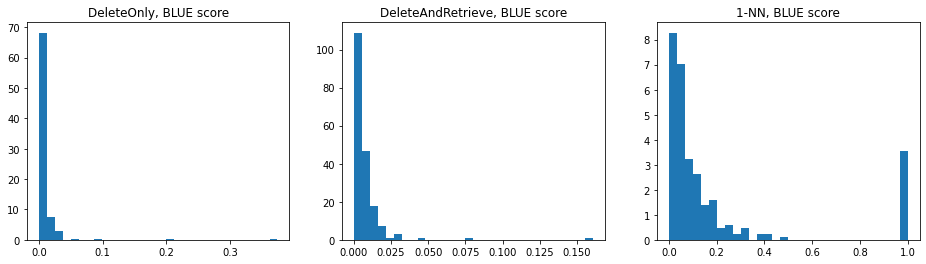

In [255]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

plt.sca(ax[0])
plt.title('DeleteOnly, BLUE score')
plt.hist(pairwise_bleu, density=True, bins=30)

plt.sca(ax[1])
plt.title('DeleteAndRetrieve, BLUE score')
plt.hist(pairwise_bleu2, density=True, bins=30)

plt.sca(ax[2])
plt.title('1-NN, BLUE score')
plt.hist(pairwise_bleu3, density=True, bins=30)

plt.show()

### 4.4 Plot histograms of event count differences (modification counts)

In [256]:
# The counts of total, drug events and procedures, for the original sequences
original_counts = pd.DataFrame(columns=['total', 'drug', 'procedure'])

In [257]:
def get_counts_table(event_sequences):
    temp_list = list()
    for seq in event_sequences:
        splitted = seq.split()
        total = len(splitted)
        # MetaVision ITEMID values are all above 220000. Since this data only contains data from MetaVision, it only contains ITEMID above 220000
        drug = len([x for x in splitted if int(x) >= 220000])
        procedure = total - drug

        temp_list.append({'total': total, 'drug': drug, 'procedure': procedure})

    return pd.DataFrame(temp_list)

In [258]:
df_original_counts = get_counts_table(original_event_sequences)

In [259]:
df_original_counts.head()

,total,drug,procedure
0,5,3,2
1,37,33,4
2,43,42,1
3,5,4,1
4,31,29,2


In [260]:
# Get count tables for all the tranformed results (generated counterfactuals)
trans_counts_delete = get_counts_table(trans_event_delete)
trans_counts_delete_retrieve = get_counts_table(trans_event_delete_retrieve)
trans_counts_one_nn = get_counts_table(trans_event_one_nn)

In [261]:
# Substract the original counts to get event modifications for total, drug events and procedures
substracted_delete = trans_counts_delete.subtract(df_original_counts)
substracted_delete_retrieve = trans_counts_delete_retrieve.subtract(df_original_counts)
substracted_one_nn = trans_counts_one_nn.subtract(df_original_counts)

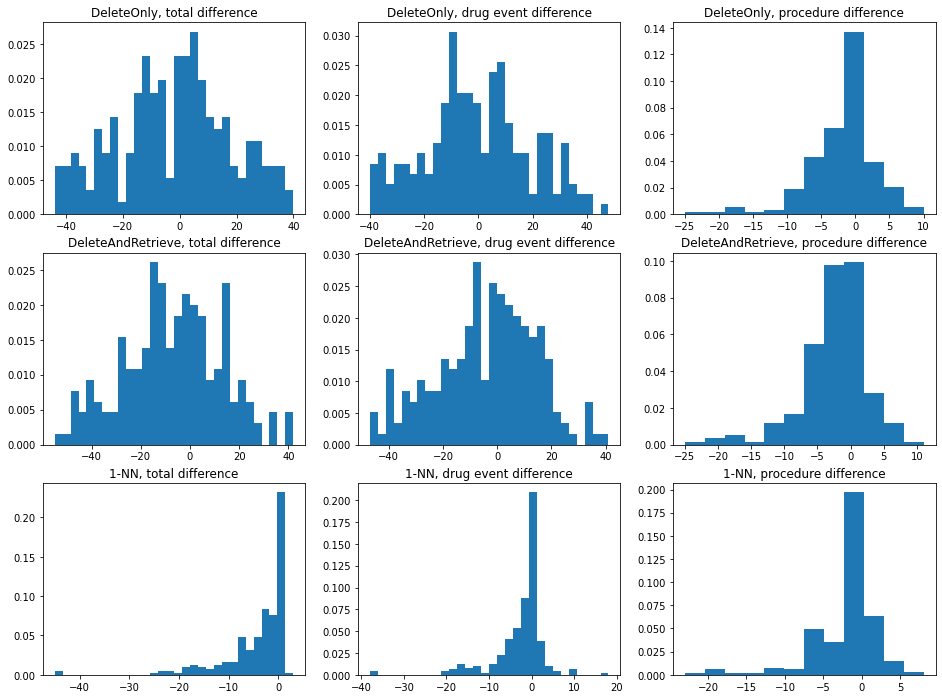

In [262]:
# Plot 3x3 subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

plt.sca(ax[0, 0])
plt.title('DeleteOnly, total difference')
plt.hist(substracted_delete['total'], density=True, bins=30)

plt.sca(ax[0, 1])
plt.title('DeleteOnly, drug event difference')
plt.hist(substracted_delete['drug'], density=True, bins=30)

plt.sca(ax[0, 2])
plt.title('DeleteOnly, procedure difference')
plt.hist(substracted_delete['procedure'], density=True, bins=12)

plt.sca(ax[1, 0])
plt.title('DeleteAndRetrieve, total difference')
plt.hist(substracted_delete_retrieve['total'], density=True, bins=30)

plt.sca(ax[1, 1])
plt.title('DeleteAndRetrieve, drug event difference')
plt.hist(substracted_delete_retrieve['drug'], density=True, bins=30)

plt.sca(ax[1, 2])
plt.title('DeleteAndRetrieve, procedure difference')
plt.hist(substracted_delete_retrieve['procedure'], density=True, bins=12)

plt.sca(ax[2, 0])
plt.title('1-NN, total difference')
plt.hist(substracted_one_nn['total'], density=True, bins=30)

plt.sca(ax[2, 1])
plt.title('1-NN, drug event difference')
plt.hist(substracted_one_nn['drug'], density=True, bins=30)

plt.sca(ax[2, 2])
plt.title('1-NN, procedure difference')
plt.hist(substracted_one_nn['procedure'], density=True, bins=12)

plt.show()

### 4.5 Export example counterfactuals 

In [263]:
# Convert id to original event name
conn = psycopg2.connect(
    database="mimic",
    user='postgres',
    password=getpass.getpass("Enter postgres password"),
    host="127.0.0.1",
    port="5432",
    options=f'-c search_path=mimiciii')
# Get a mapping from itemid to name (drug events)
itemid_to_name = pd.read_sql(
    """
    SELECT itemid, abbreviation, label
    FROM d_items;
    """, conn)

itemid_to_name = itemid_to_name[itemid_to_name['itemid'] >= 220000]
itemid_to_name.head()

,itemid,abbreviation,label
8673,221015,Ensure,Ensure
8674,221016,Ensure Plus,Ensure Plus
8675,221017,"Dextrose 2,5%","Dextrose 2,5%"
8676,225166,Potassium Chloride - KCL,Potassium Chloride
8677,225167,Hydrochloric Acid - HCL,Hydrochloric Acid - HCL


In [264]:
# Get another mapping from procedure itemid to name 
itemid_to_name2 = pd.read_sql(
    """
    SELECT icd9_code, short_title, long_title
    FROM d_icd_procedures;
    """, conn)

itemid_to_name2.head()

,icd9_code,short_title,long_title
0,0851,Canthotomy,Canthotomy
1,0852,Blepharorrhaphy,Blepharorrhaphy
2,0859,Adjust lid position NEC,Other adjustment of lid position
3,0861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,0862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...


In [265]:
# Concate two itemid_to_name into one table
itemid_to_name2 = itemid_to_name2.rename(
    columns={'icd9_code': 'itemid', 'short_title': 'abbreviation', 'long_title': 'label'})

itemid_to_name_concat = pd.concat([itemid_to_name, itemid_to_name2])

In [266]:
# Convert data type to be consistent when filtering, e.g. 'itemid_to_name_concat['itemid'] == 9671'
itemid_to_name_concat['label'] = itemid_to_name_concat['label'].astype('str')
itemid_to_name_concat['itemid'] = itemid_to_name_concat['itemid'].astype('int')

In [267]:
# Define a method to convert event codes to original names
def code_to_name(event_sequence):
    code_sequence = [int(event) for event in event_sequence.split()]

    temp_list = list()
    for code in code_sequence:
        event_name = itemid_to_name_concat[itemid_to_name_concat['itemid'] == code]['label'].item()
        temp_list.append(event_name)

    return temp_list

In [268]:
# Get the sample for example counterfactuals
sample_id = 44

In [269]:
code_to_name(original_event_sequences[sample_id])

['Packed Red Blood Cells',
 'Packed Red Blood Cells',
 'Packed Red Blood Cells',
 'Hydralazine',
 'Packed Red Blood Cells',
 'Ciprofloxacin',
 'Packed Red Blood Cells',
 'Hydralazine',
 'Labetalol',
 'Hydralazine',
 'Labetalol',
 'Labetalol',
 'Midazolam (Versed)',
 'Fentanyl',
 'Pantoprazole (Protonix)',
 'Hydralazine',
 'Hydralazine',
 'Pantoprazole (Protonix)',
 'Other endoscopy of small intestine',
 'Esophagogastroduodenoscopy [EGD] with closed biopsy']

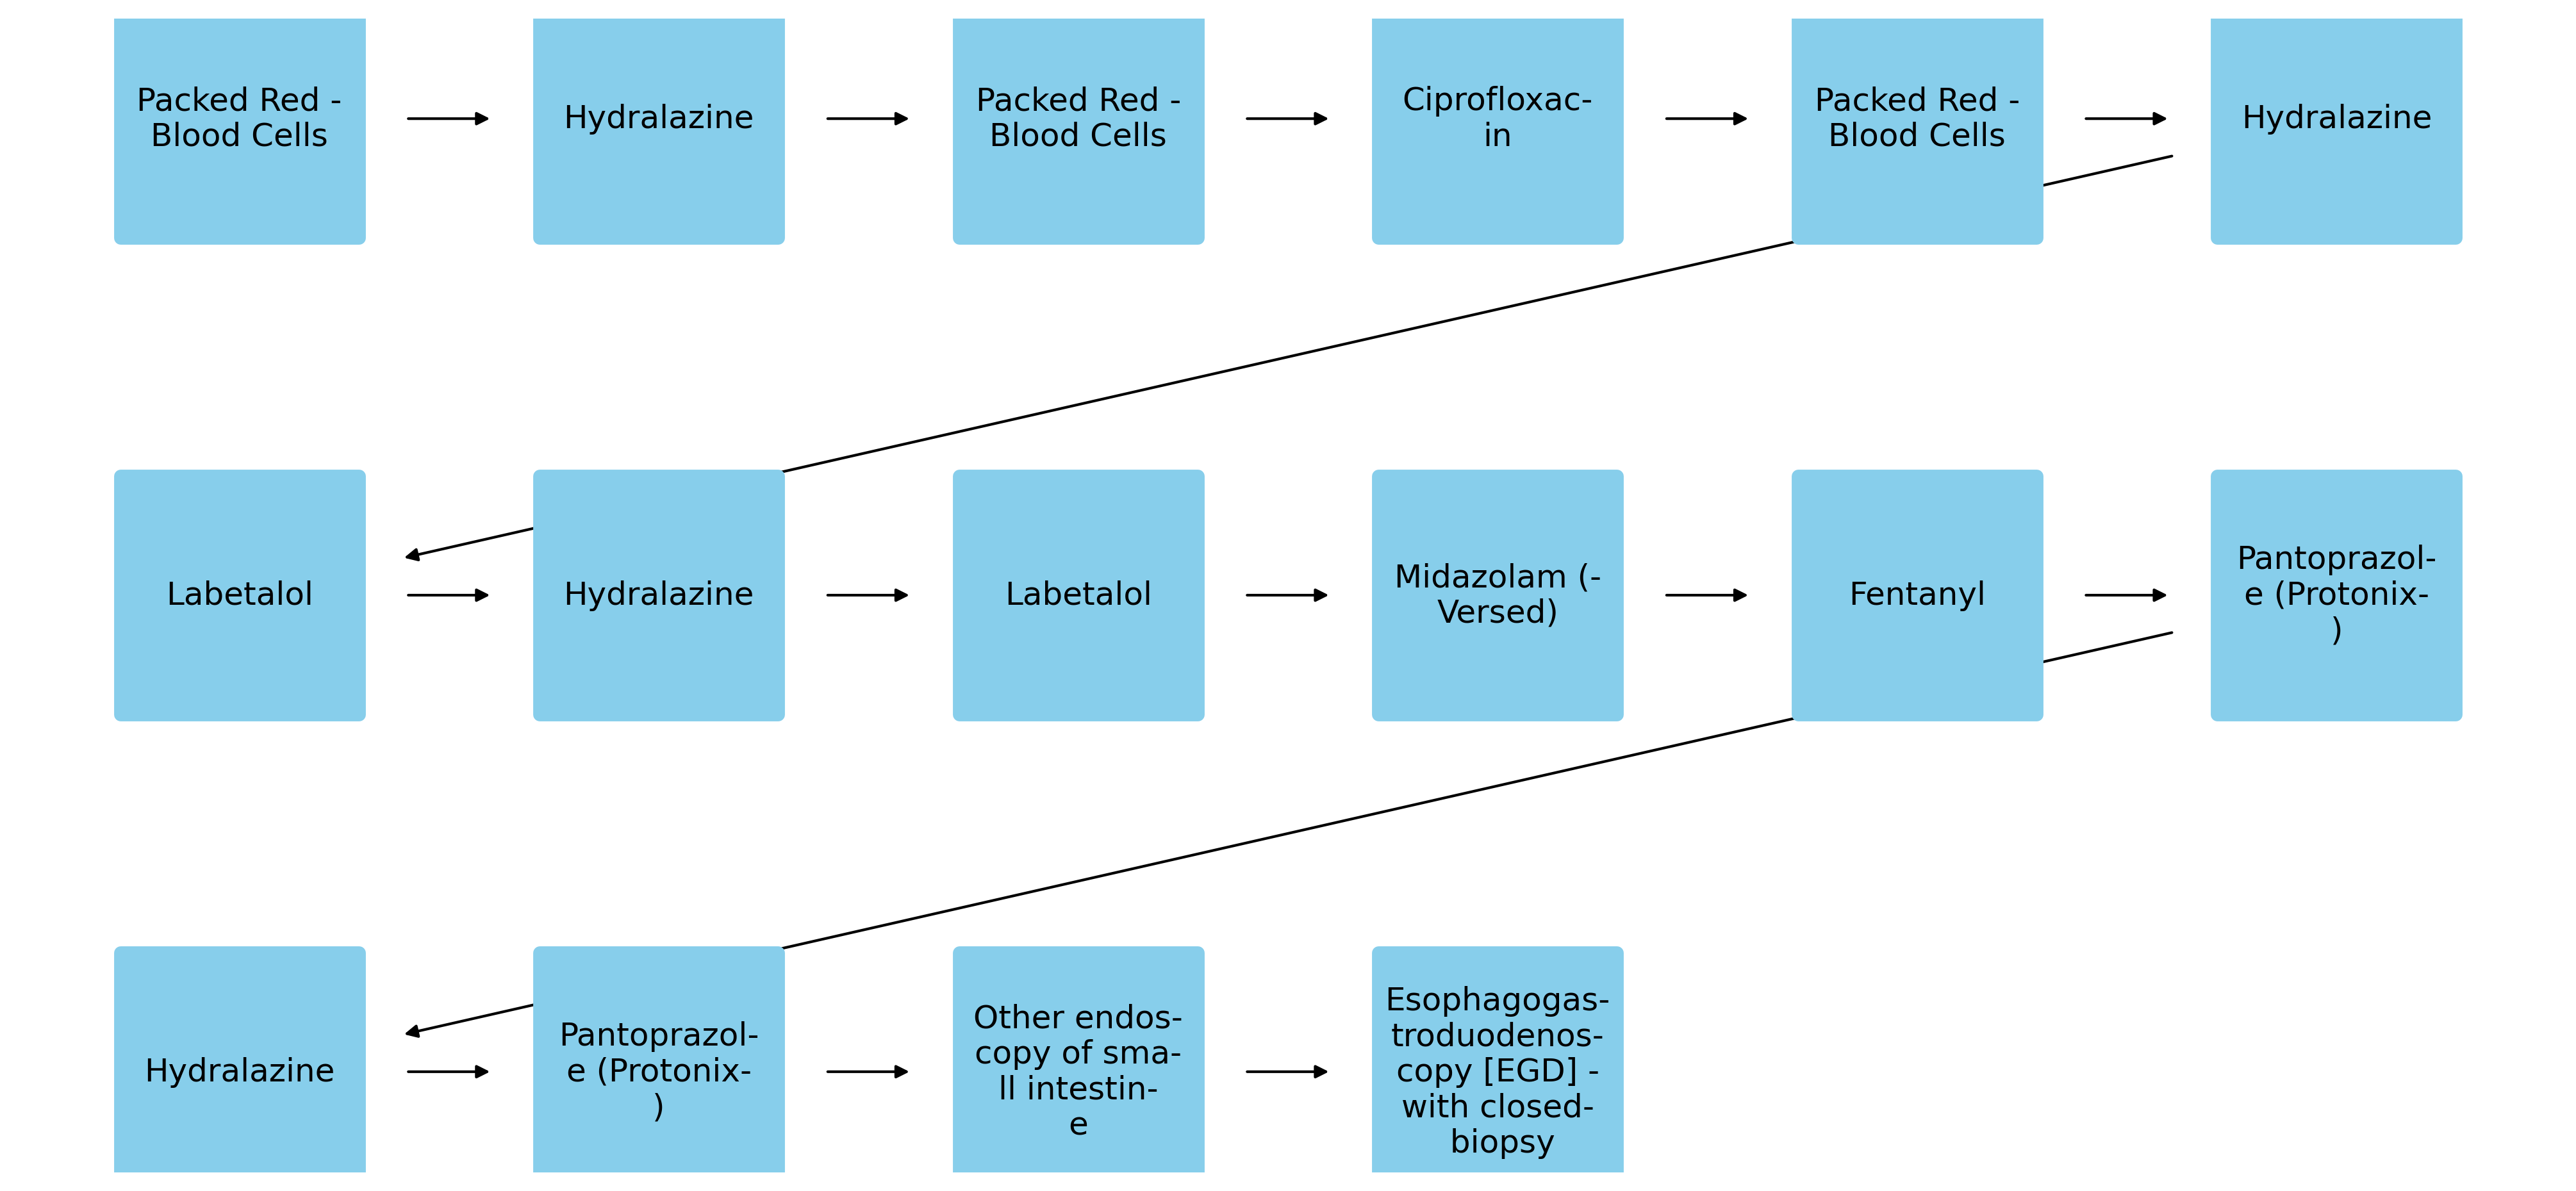

In [270]:
plot_sequence(
    code_to_name(original_event_sequences[sample_id])
)

In [271]:
# original_event_sequences[sample_id]

In [272]:
code_to_name(trans_event_delete[sample_id])

['Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Calcium Gluconate',
 'Piggyback',
 'Calcium Gluconate',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'D5NS',
 'Calcium Gluconate',
 'Piggyback',
 'Dilantin',
 'Heparin Sodium (Prophylaxis)',
 'Dilantin',
 'Dilantin',
 'Metoprolol',
 'Heparin Sodium (Prophylaxis)',
 'Continuous invasive mechanical ventilation for less than 96 consecutive hours',
 'Bronchial dilation',
 'Other intubation of respiratory tract']

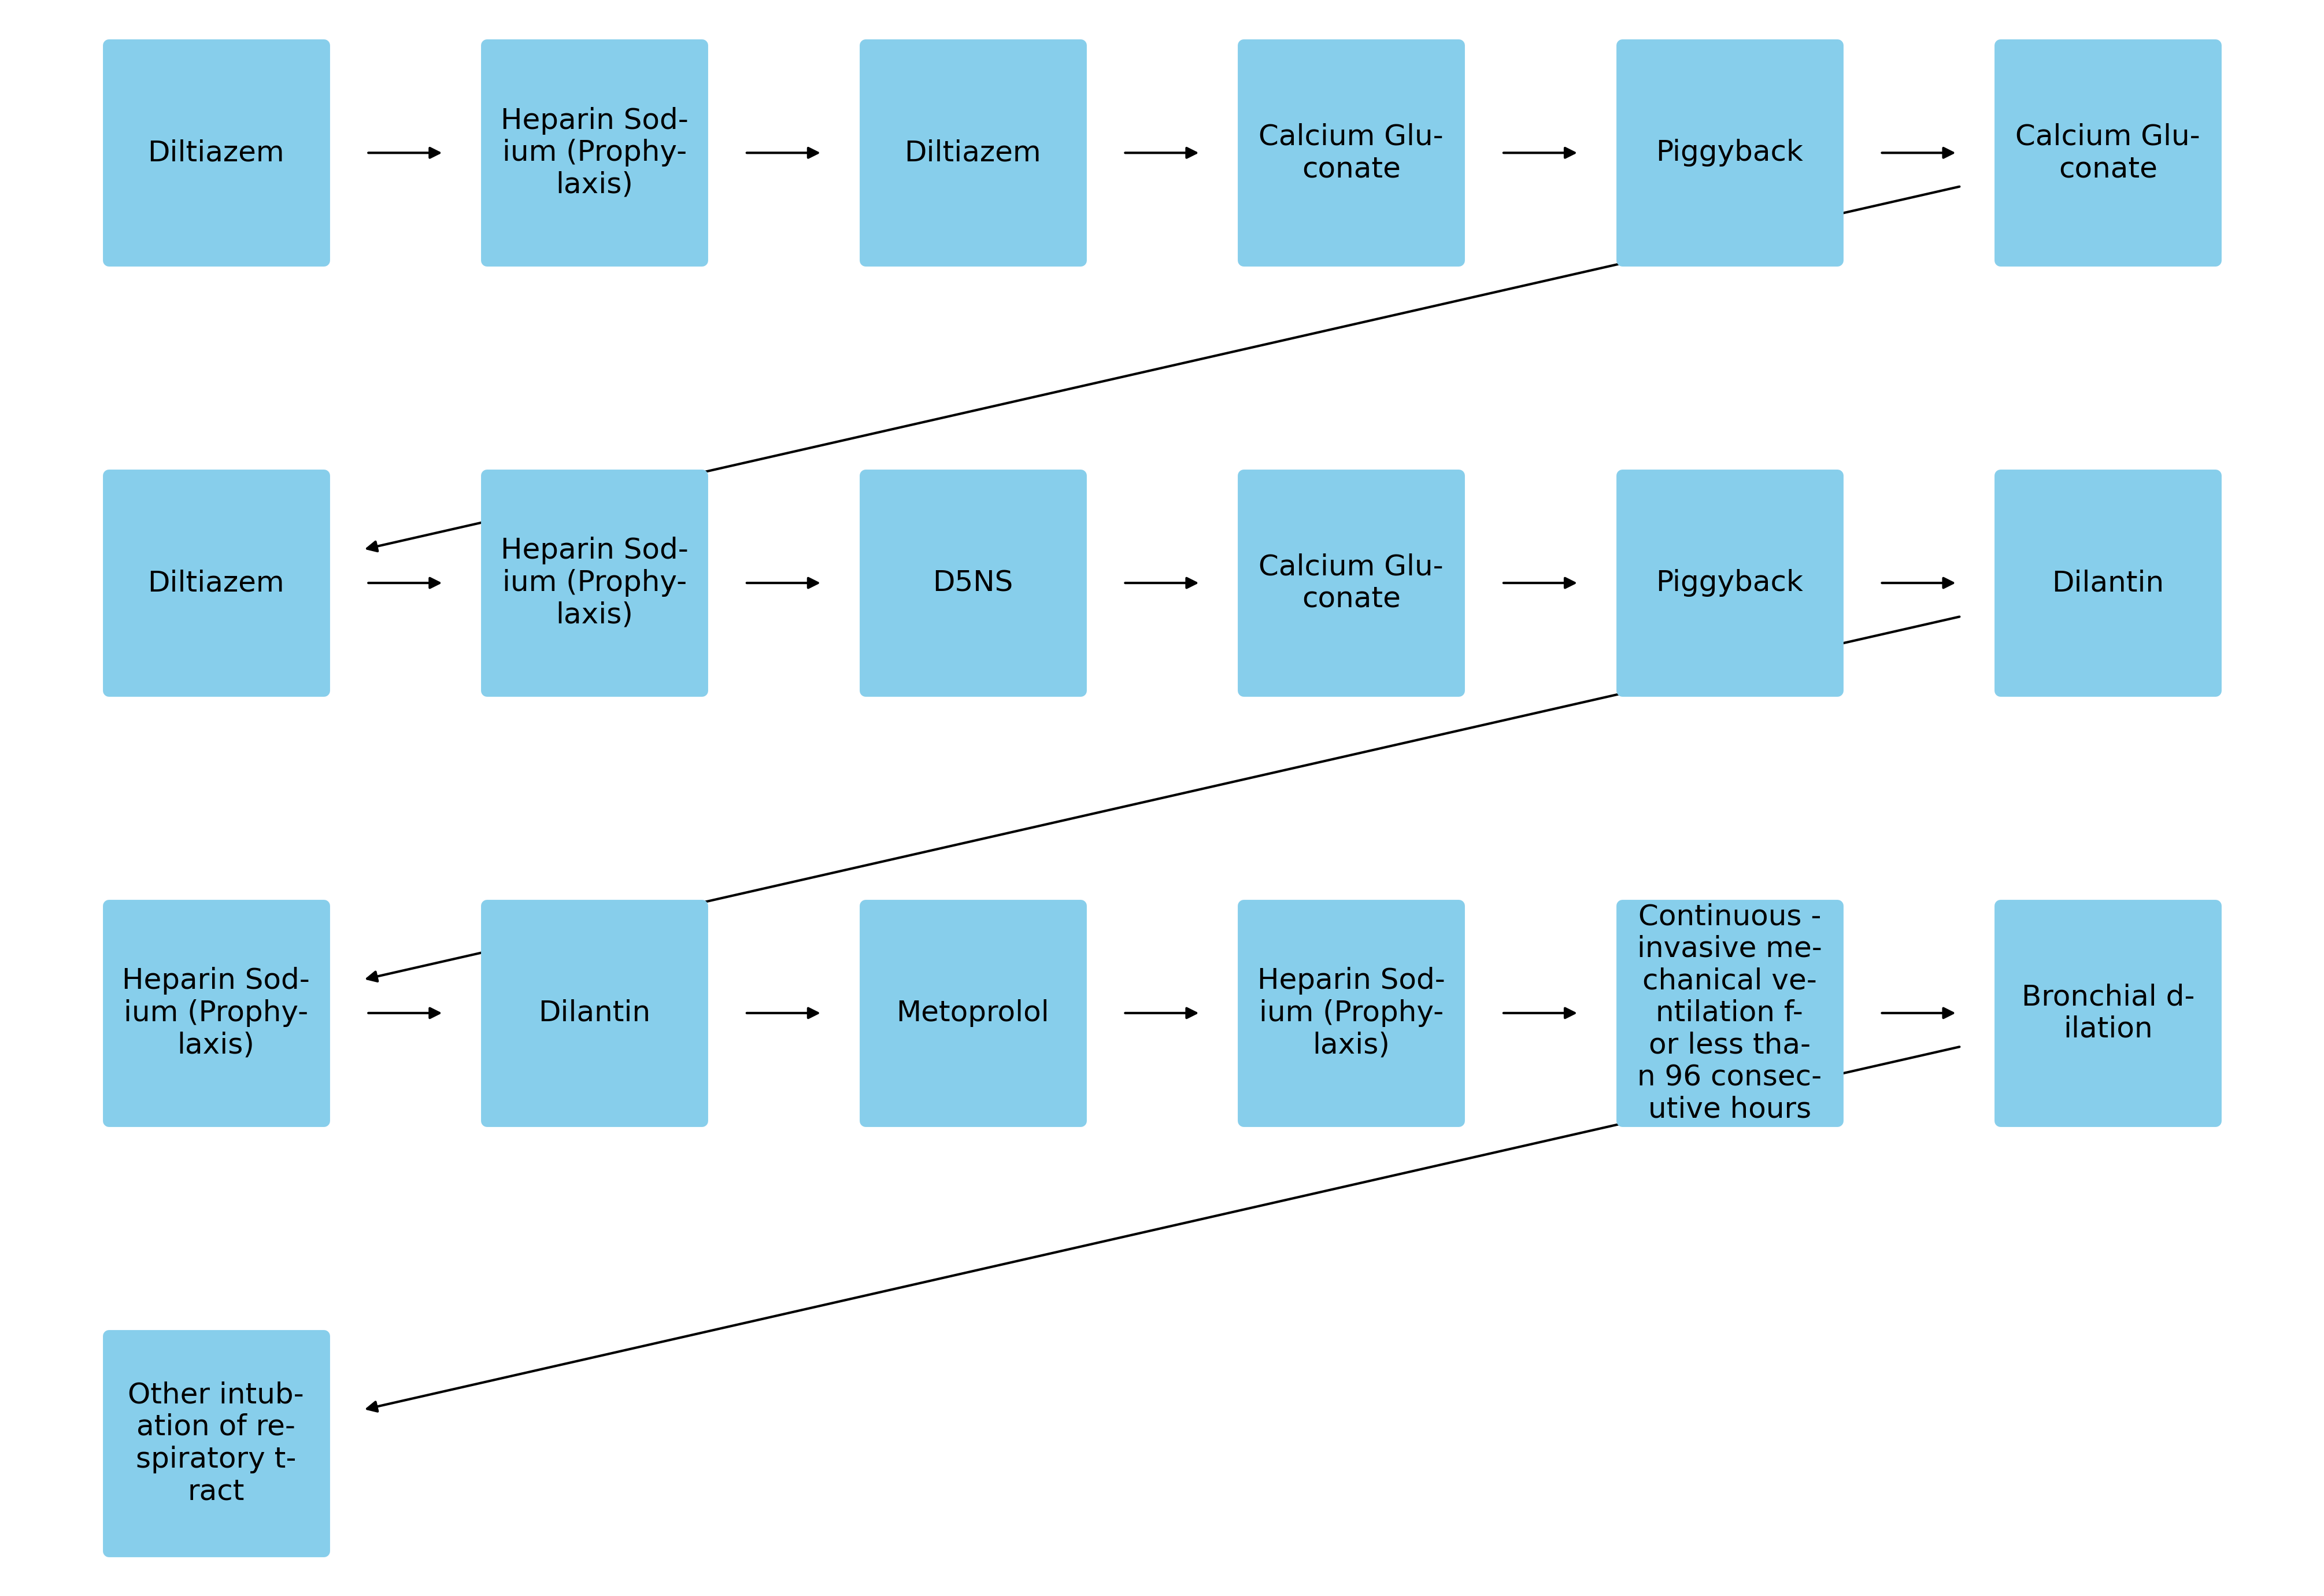

In [273]:
plot_sequence(
    code_to_name(trans_event_delete[sample_id])
)

In [274]:
# trans_event_sequences1[sample_id]

In [275]:
code_to_name(trans_event_delete_retrieve[sample_id])

['Cath Lab Intake',
 'NaCl 0.45%',
 'Other endovascular procedures on other vessels',
 'Aortography',
 'Arteriography of other intra-abdominal arteries',
 'Injection or infusion of other therapeutic or prophylactic substance',
 'Aortography']

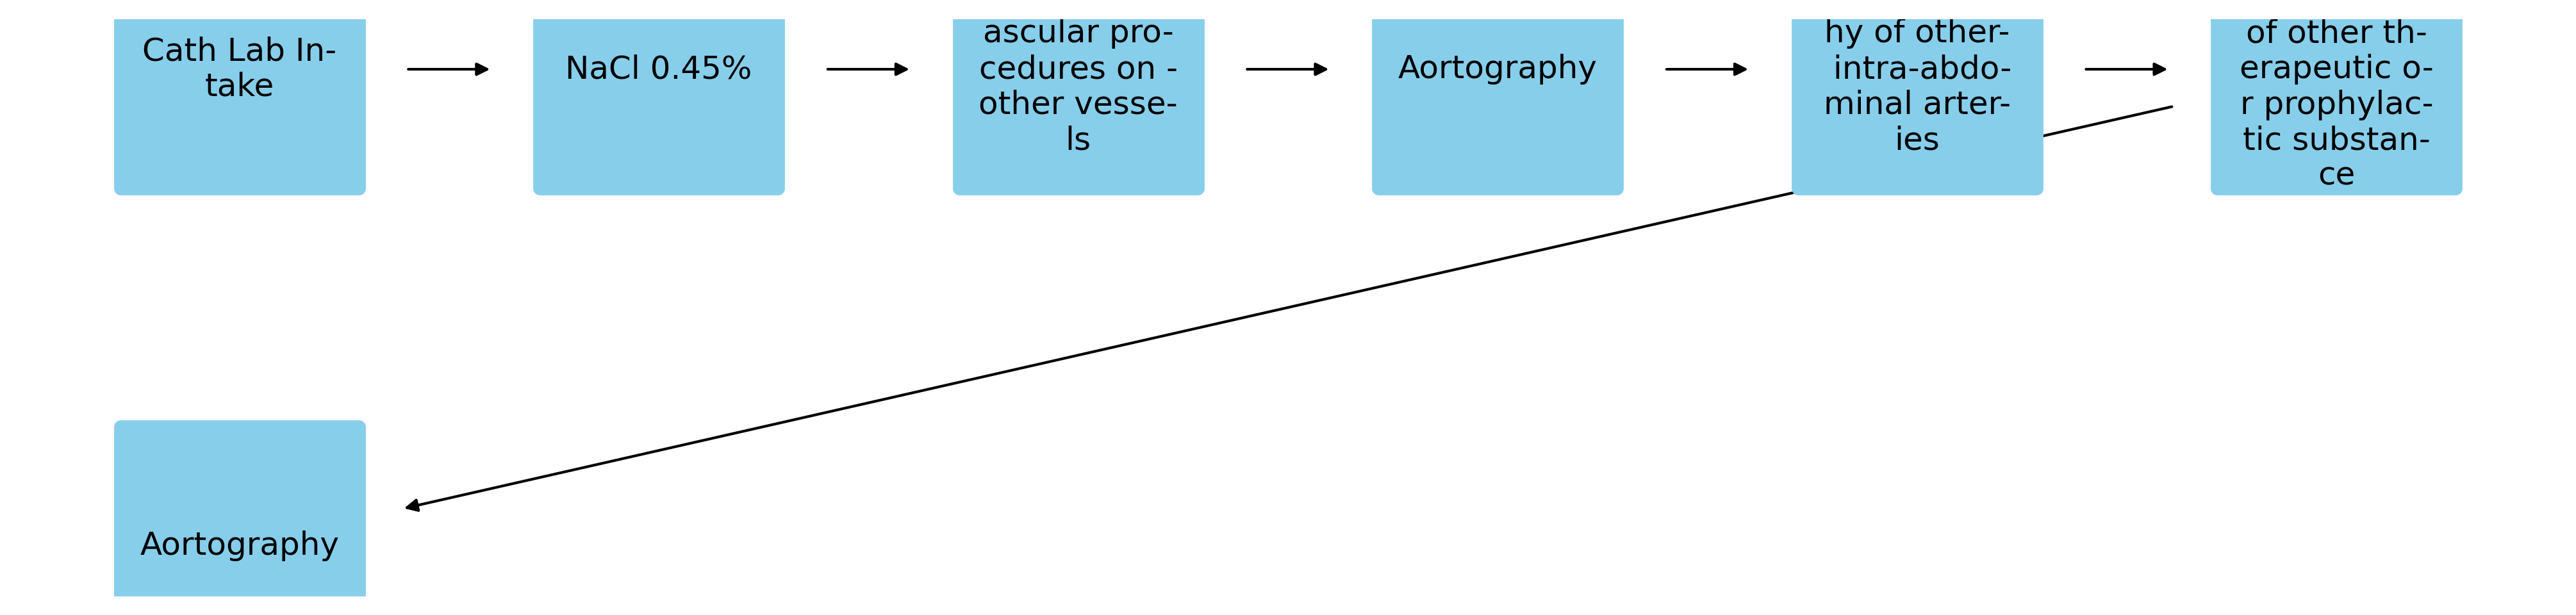

In [276]:
plot_sequence(
    code_to_name(trans_event_delete_retrieve[sample_id])
)

In [277]:
# trans_event_sequences2[sample_id]

In [278]:
code_to_name(trans_event_one_nn[sample_id])

['Packed Red Blood Cells',
 'Packed Red Blood Cells',
 'Packed Red Blood Cells',
 'Packed Red Blood Cells',
 'Packed Red Blood Cells',
 'Calcium Gluconate',
 'Packed Red Blood Cells',
 'Gastric Meds',
 'Gastric Meds',
 'Magnesium Sulfate (Bolus)',
 'Magnesium Sulfate',
 'Gastric Meds',
 'D5NS',
 'OR Crystalloid Intake',
 'Endoscopic destruction of other lesion or tissue of large intestine']

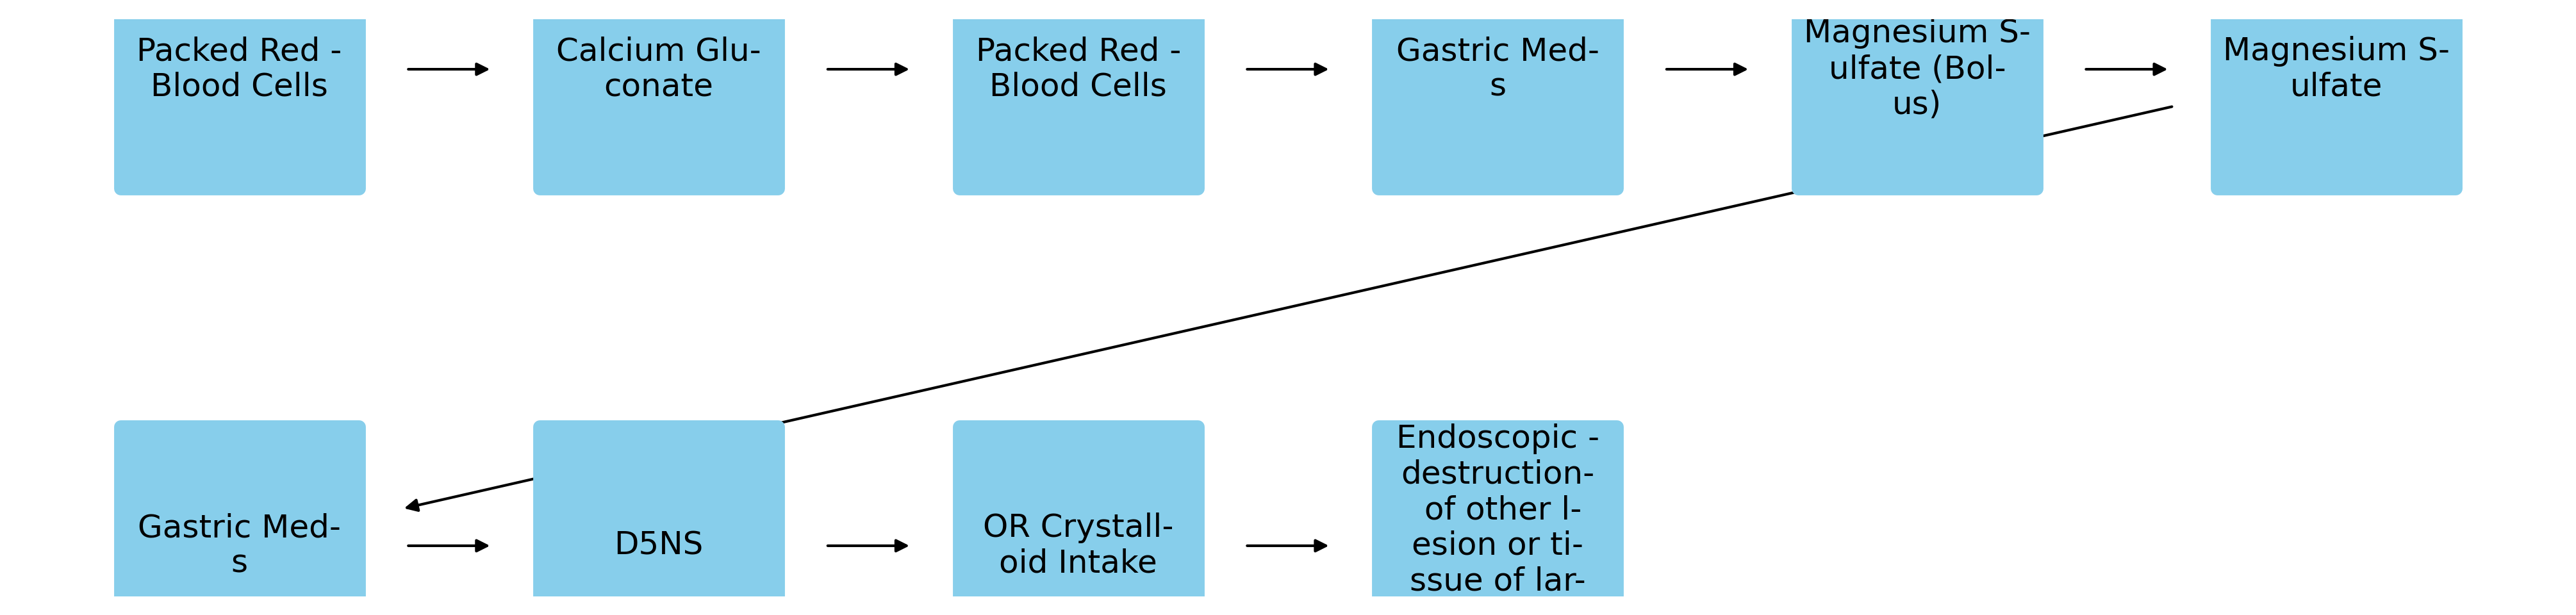

In [279]:
plot_sequence(
    code_to_name(trans_event_one_nn[sample_id])
)

In [280]:
# trans_event_sequences3[sample_id]